In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

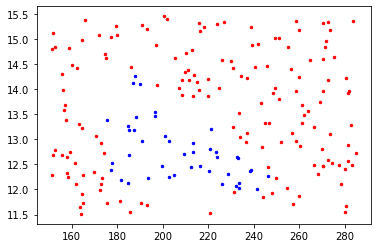

In [3]:
x, y = load_coffee_data()
pos = y == 1
neg = y == 0


good_1 = x[:,0].reshape((-1,1))[pos]
good_2 = x[:,1].reshape((-1,1))[pos]
good_X = np.vstack([good_1, good_2])
good_X = good_X.transpose()

bad_1 = x[:,0].reshape((-1,1))[neg]
bad_2 = x[:,1].reshape((-1,1))[neg]
bad_X = np.vstack([bad_1, bad_2])
bad_X = bad_X.transpose()

fig, ax = plt.subplots()
ax.scatter(bad_X[:,0], bad_X[:,1], label = "Bad roast", c = "red", s = 6)
ax.scatter(good_X[:,0], good_X[:,1], label = "Good roast", c = "blue", s = 6)
plt.show()

In [4]:
# Creting a normalization layer
normLayer = tf.keras.layers.Normalization(axis = -1)
normLayer.adapt(x)
xNorm = normLayer(x)

# Tile the data
Xt = np.tile(xNorm,(1000,1))
Yt= np.tile(y,(1000,1))   
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


In [5]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(units=3, activation="sigmoid", name = "layer1"),
        tf.keras.layers.Dense(units=1, activation="sigmoid", name = "layer2")
    ]
)

model.summary()

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6250/6250 [==============================] - 6s 896us/step - loss: 0.2043
Epoch 2/10
6250/6250 [==============================] - 6s 882us/step - loss: 0.0886
Epoch 3/10
6250/6250 [==============================] - 5s 824us/step - loss: 0.0221
Epoch 4/10
6250/6250 [==============================] - 5s 791us/step - loss: 0.0129
Epoch 5/10
6250/6250 [==============================] - 5s 822us/step - loss: 0.0088
Epoch 6/10
6250/6250 [=========

In [7]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)


W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

W1:
 [[ -0.11243525  14.880138   -10.980034  ]
 [ -9.095663    12.334794    -0.2584009 ]] 
b1: [-11.38634     1.9326813 -11.93876  ]
W2:
 [[-47.369175]
 [-42.61146 ]
 [-51.368244]] 
b2: [27.169247]


1/1 [==============================] - 0s 23ms/step
Predictions: 
 [[9.9999970e-01]
 [9.9999946e-01]
 [3.2241498e-08]]


x : Bad roast prediction
+ : Good roast prediction


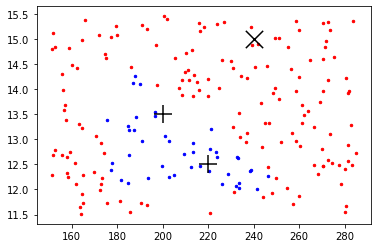

In [24]:
# Testing the results
xTest = np.array([
    [200, 13.5],
    [220, 12.5],
    [240,15]
])

nTestNorm = normLayer(xTest)
predictions = model.predict(nTestNorm)

print(f"Predictions: \n", predictions)

fig, ax = plt.subplots()
ax.scatter(bad_X[:,0], bad_X[:,1], label = "Bad roast", c = "red", s = 6)
ax.scatter(good_X[:,0], good_X[:,1], label = "Good roast", c = "blue", s = 6)

print("\n\nx : Bad roast prediction\n+ : Good roast prediction")

for i in range(xTest.shape[0]):
    if predictions[i] <= 0.5:
        mark = "x"
    else:
        mark = "+"

    ax.scatter(xTest[i,0], xTest[i,1], label = "Test", c = "black", s = 300, marker = mark)

plt.show()